In [1]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import requests
from matplotlib import cbook, dates
from datetime import date, timedelta, datetime
from itertools import product


Bad key "text.kerning_factor" on line 4 in
C:\Users\bcpython\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Downloading the data

downloadUrl = 'https://covid19.ssp.df.gov.br/resources/dados/dados-abertos.csv?param=[random]'
req = requests.get(downloadUrl)
filename = 'dados-abertos.csv'

with open(filename,'wb') as f:
    for chunk in req.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
            
def download_file(url,filename=''):
    try:
        if filename:
            pass
        else:
            filename = req.url[downloadUrl.rfind('/')+1:]

        with requests.get(url) as req:
            with open(filename,'wb') as f:
                for chunk in req.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            return filename
    except Exception as e:
        print(e)
        return None
    
download_file(downloadUrl,'covid_data_brasilia.csv')

'covid_data_brasilia.csv'

In [3]:
#Loading and preparing the dataframes

df = pd.read_csv('covid_data_brasilia.csv', sep = ';')
df = pd.DataFrame(df)
cols = ['Data','Sexo','UF','dataPrimeirosintomas','Pneumopatia','Nefropatia','Doença Hematológica','Distúrbios Metabólicos','Imunopressão','Obesidade','Outros','Cardiovasculopatia','Idade']
df.drop(columns = cols,inplace=True)
df_deaths = df[df['Óbito'] == 'Sim']

In [4]:
#Preparing the dataframes to merge on each date on the interval since the first case of COVID
#Also we use dateage to create a single key for each age interval on each day of the series for cases and deaths

df['data'] = pd.to_datetime(df['Data Cadastro'], dayfirst = True)
df.drop(columns = 'Data Cadastro', inplace=True)
df.fillna(method='ffill', inplace = True)
df['qtd'] = 1
df['datastring'] = df['data'].dt.strftime('%Y-%m-%d')
df['dateage'] = df['datastring'] + df['Faixa Etária']
df.drop(columns = 'datastring', inplace = True)
max_date = max(df['data'])
max_date = max_date.to_pydatetime().date()

df_deaths['data_obito'] = pd.to_datetime(df_deaths['Data Cadastro'], dayfirst = True)
df_deaths.drop(columns = 'Data Cadastro', inplace=True)
df_deaths.fillna(method='ffill', inplace = True)
df_deaths['qtd'] = 1
df_deaths['datastring'] = df_deaths['data_obito'].dt.strftime('%Y-%m-%d')
df_deaths['dateage'] = df_deaths['datastring'] + df_deaths['Faixa Etária']
df_deaths.drop(columns = 'datastring', inplace = True)

C:\Users\bcpython\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\bcpython\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\bcpython\anaconda3\lib\site-packages\pandas\core\frame.py:4465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=d

In [5]:
#Creating a list with every date since the first case of COVID (16/3/2020)

def rangedata(data1, data2):
    for n in range(int((data2 - data1).days)+1):
        yield data1 + timedelta(n)
        
date_list = []
end_date = max_date
beg_date = date(2020,3,16)
for dt in rangedata(beg_date, end_date):
    date_list.append(dt.strftime("%Y-%m-%d"))

In [6]:
#Creating a list with every age interval

ages = []
for x in df['Faixa Etária'].unique():
    ages.append(x)

In [7]:
#Create a dataframe with every date for every age interval and its unique key

df_aux = pd.DataFrame(list(product(date_list,ages)))
df_aux.columns = ['date','age']
df_aux['dateage'] = df_aux['date'] + df_aux['age']
df_aux

,date,age,dateage
0,2020-03-16,50 a 59 anos,2020-03-1650 a 59 anos
1,2020-03-16,40 a 49 anos,2020-03-1640 a 49 anos
2,2020-03-16,>= 60 anos,2020-03-16>= 60 anos
3,2020-03-16,20 a 29 anos,2020-03-1620 a 29 anos
4,2020-03-16,30 a 39 anos,2020-03-1630 a 39 anos
...,...,...,...
2377,2021-04-16,40 a 49 anos,2021-04-1640 a 49 anos
2378,2021-04-16,>= 60 anos,2021-04-16>= 60 anos
2379,2021-04-16,20 a 29 anos,2021-04-1620 a 29 anos
2380,2021-04-16,30 a 39 anos,2021-04-1630 a 39 anos


In [8]:
#Preparing the cases and deaths DF for the merge

df_cases = df.groupby('dateage').agg('sum')
df_deaths = df_deaths.groupby('dateage').agg('sum')

In [9]:
#Merging the cases DF with the auxiliar DF

df_cases = pd.merge(df_aux,df_cases,left_on='dateage',right_on='dateage', how='left')
df_cases.drop(columns = 'dateage', inplace=True)
df_cases.columns = ['date','age','cases']
df_cases.groupby(['age','date'], as_index =  False).agg({'cases':'sum'}).sort_values(by=['age','date'], ascending = True).reset_index(drop=True)
df_cases['cumcases'] = df_cases.groupby('age')['cases'].cumsum()
df_cases

,date,age,cases,cumcases
0,2020-03-16,50 a 59 anos,NaN,NaN
1,2020-03-16,40 a 49 anos,NaN,NaN
2,2020-03-16,>= 60 anos,NaN,NaN
3,2020-03-16,20 a 29 anos,NaN,NaN
4,2020-03-16,30 a 39 anos,1.0,1.0
...,...,...,...,...
2377,2021-04-16,40 a 49 anos,247.0,80818.0
2378,2021-04-16,>= 60 anos,183.0,48224.0
2379,2021-04-16,20 a 29 anos,180.0,62483.0
2380,2021-04-16,30 a 39 anos,226.0,92296.0


In [10]:
#Merging the deaths DF with the auxiliar DF

df_deaths = pd.merge(df_aux,df_deaths,left_on='dateage',right_on='dateage', how='left')
df_deaths.drop(columns = 'dateage', inplace=True)
df_deaths.columns = ['date','age','deaths']
df_deaths.groupby(['age','date'], as_index =  False).agg({'deaths':'sum'}).sort_values(by=['age','date'], ascending = True).reset_index(drop=True)
df_deaths['cumdeaths'] = df_deaths.groupby('age')['deaths'].cumsum()
df_deaths

,date,age,deaths,cumdeaths
0,2020-03-16,50 a 59 anos,NaN,NaN
1,2020-03-16,40 a 49 anos,NaN,NaN
2,2020-03-16,>= 60 anos,NaN,NaN
3,2020-03-16,20 a 29 anos,NaN,NaN
4,2020-03-16,30 a 39 anos,NaN,NaN
...,...,...,...,...
2377,2021-04-16,40 a 49 anos,1.0,621.0
2378,2021-04-16,>= 60 anos,7.0,5170.0
2379,2021-04-16,20 a 29 anos,NaN,NaN
2380,2021-04-16,30 a 39 anos,NaN,NaN


In [11]:
#We filter on the DFs only people with over 60 years and creating a column with the moving average of 7 days

df60_cases = df_cases[df_cases['age'] == '>= 60 anos'].reset_index(drop=True)
df60_cases['ma7']= df60_cases['cases'].rolling(window = 7, min_periods=1).mean()
df60_cases.date = pd.to_datetime(df60_cases.date)

df60_deaths = df_deaths[df_cases['age'] == '>= 60 anos'].reset_index(drop=True)
df60_deaths['ma7']= df60_deaths['deaths'].rolling(window = 7, min_periods=1).mean()
df60_deaths.date = pd.to_datetime(df60_deaths.date)

In [12]:
# Creating a list with the dates of the events we want to show on the timeline, another list with its names 
# and two others with how many cases and deaths we had in each of these dates as we need it to plot the texts
# on the right coordinates.

datas_eventos = ["03/18/2020", #1º lockdown
                 "05/27/2020", #Reabertura Comércio
                 "07/15/2020", #Reabertura bares e restaura
                 "12/25/2020", #Natal
                 "2/1/2021", #Início Vacinação +80 anos
                 "2/15/2021", #Carnaval
                 "3/1/2021", #Lockdown e toque de recolher
                 "3/4/2021", #Início Vacinação +75 anos
                 "3/25/2021"] #Início Vacinação +70 anos

datas_eventos = [datetime.strptime(x, '%m/%d/%Y') for x in datas_eventos]

nomes_eventos = ["1º lockdown",
                 "Reabertura comércio",
                "Reabertura bares e restaurantes",
                "Natal",
                "Início Vacinação +80 anos",
                "Carnaval",
                "Lockdown e Toque de Recolher",
                "Início Vacinação +75 anos",
                "Início Vacinação +70 anos"]

df_eventos_casos = df60_cases[df60_cases.date.isin(datas_eventos)].reset_index(drop=True)
df_eventos_casos['ma7'] = df_eventos_casos['ma7'].fillna(0)
df_eventos_casos['ma7'] = df_eventos_casos['ma7'].astype(int)
lista_eventos_casos = list(df_eventos_casos['ma7'])

df_eventos_mortes = df60_deaths[df60_deaths.date.isin(datas_eventos)].reset_index(drop=True)
df_eventos_mortes['ma7'] = df_eventos_mortes['ma7'].fillna(0)
df_eventos_mortes['ma7'] = df_eventos_mortes['ma7'].astype(int)
lista_eventos_mortes = list(df_eventos_mortes['ma7'])

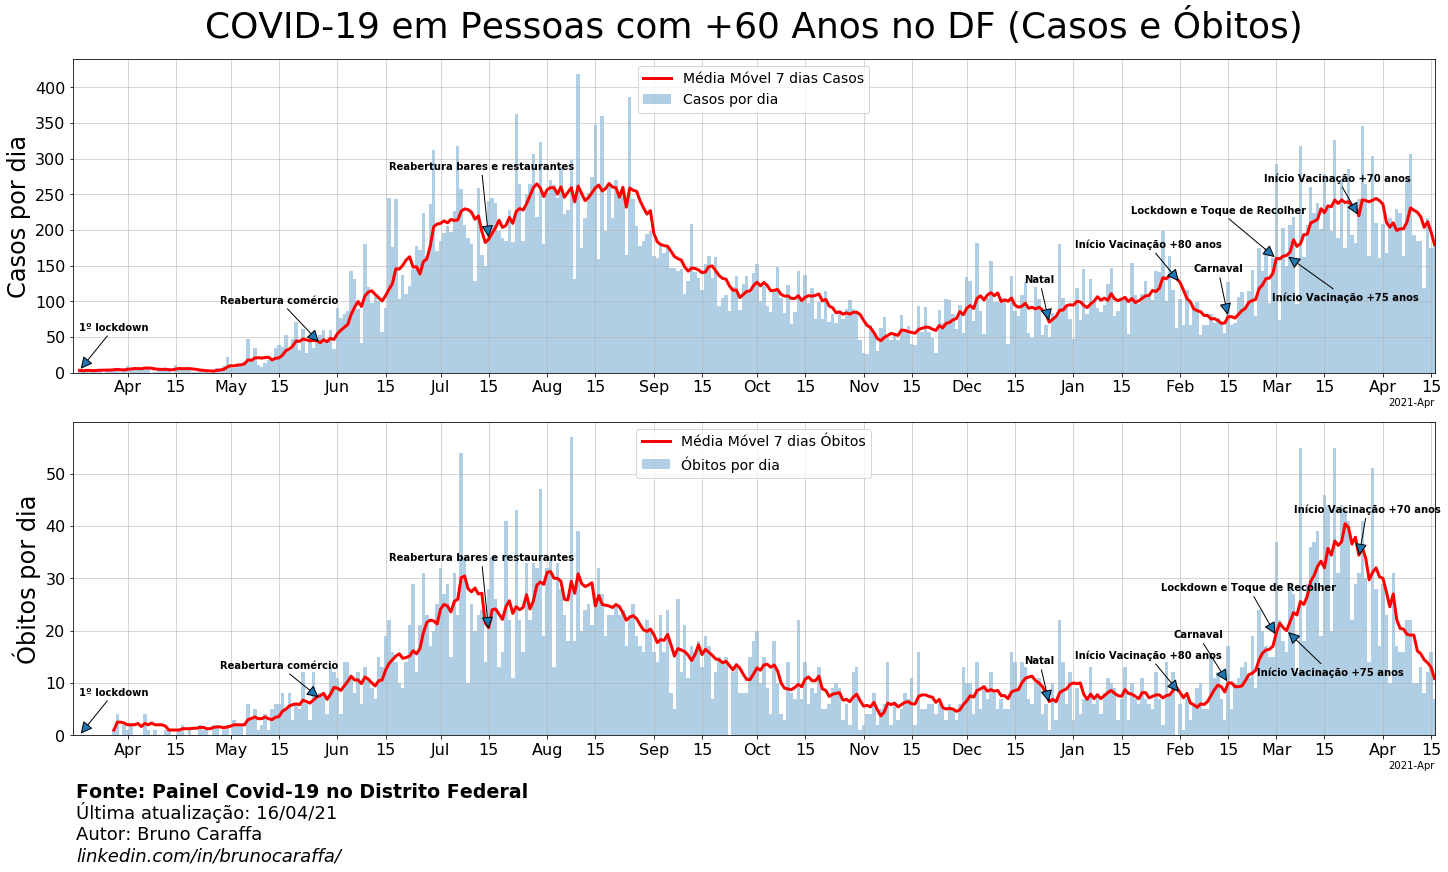

In [13]:
#Plotting the timeline

x_cases = df60_cases['date']
y_cases= df60_cases['ma7']
y2_cases= df60_cases['cases']

x_deaths = df60_deaths['date']
y_deaths= df60_deaths['ma7']
y2_deaths=df60_deaths['deaths']

fig, (ax1,ax2) = plt.subplots(2,figsize = (20,12), constrained_layout = True)
ax1.bar(x_cases,y2_cases, label = 'Casos por dia', alpha = 0.35, width = 1)
ax1.plot(x_cases,y_cases, color = 'red',linewidth=3, label ='Média Móvel 7 dias Casos')
ax1.set_ylabel('Casos por dia', fontsize = 24)
locator = dates.AutoDateLocator(minticks = 20, maxticks = 40)
formatter = dates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.set_xlim(beg_date,end_date)
ax1.grid(alpha = 0.65)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(loc='upper center', fontsize = 14)
ax1.set_title('COVID-19 em Pessoas com +60 Anos no DF (Casos e Óbitos)', fontsize = 36)
tt = ax1.title
tt.set_position([.5,1.05])
ax2.bar(x_deaths,y2_deaths, label = 'Óbitos por dia', alpha = 0.35, width = 1)
ax2.plot(x_deaths,y_deaths, color = 'red',linewidth=3, label ='Média Móvel 7 dias Óbitos')
ax2.set_ylabel('Óbitos por dia', fontsize = 24)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xlim(beg_date,end_date)
ax2.grid(alpha = 0.65)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.text(datetime(2020,3,17),-12,'Fonte: Painel Covid-19 no Distrito Federal',fontsize=19, weight='bold')
ax2.text(datetime(2020,3,17),-16,f'Última atualização: {max_date:%d/%m/%y}',fontsize=18)
ax2.text(datetime(2020,3,17),-20,'Autor: Bruno Caraffa',fontsize=18)
ax2.text(datetime(2020,3,17),-24,'linkedin.com/in/brunocaraffa/',fontsize=18, style='italic')
ax2.legend(loc='upper center', fontsize = 14)

#Plotting the arrows with the events

ax1.annotate(nomes_eventos[0],
            (datas_eventos[0], lista_eventos_casos[0]),
            xytext=(0,40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[1],
            (datas_eventos[1], lista_eventos_casos[1]),
            xytext=(-100,40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[2],
            (datas_eventos[2], lista_eventos_casos[2]),
            xytext=(-100,70),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[3],
            (datas_eventos[3], lista_eventos_casos[3]),
            xytext=(-25,40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[4],
            (datas_eventos[4], lista_eventos_casos[4]),
            xytext=(-105,35),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[5],
            (datas_eventos[5], lista_eventos_casos[5]),
            xytext=(-35,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[6],
            (datas_eventos[6], lista_eventos_casos[6]),
            xytext=(-145,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[7],
            (datas_eventos[7], lista_eventos_casos[7]),
            xytext=(-15,-45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax1.annotate(nomes_eventos[8],
            (datas_eventos[8], lista_eventos_casos[8]),
            xytext=(-95,35),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[0],
            (datas_eventos[0], lista_eventos_mortes[0]),
            xytext=(0,40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[1],
            (datas_eventos[1], lista_eventos_mortes[1]),
            xytext=(-100,30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[2],
            (datas_eventos[2], lista_eventos_mortes[2]),
            xytext=(-100,70),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[3],
            (datas_eventos[3], lista_eventos_mortes[3]),
            xytext=(-25,40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[4],
            (datas_eventos[4], lista_eventos_mortes[4]),
            xytext=(-105,35),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[5],
            (datas_eventos[5], lista_eventos_mortes[5]),
            xytext=(-55,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[6],
            (datas_eventos[6], lista_eventos_mortes[6]),
            xytext=(-115,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[7],
            (datas_eventos[7], lista_eventos_mortes[7]),
            xytext=(-30,-45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

ax2.annotate(nomes_eventos[8],
            (datas_eventos[8], lista_eventos_mortes[8]),
            xytext=(-65,45),
            textcoords='offset points',
            arrowprops=dict(arrowstyle = '-|>',
                           mutation_scale=25),
            weight='bold', fontsize = 10)

plt.savefig('mediamovel.png')
plt.show()